In [2]:
import os
import re
import sqlite3

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from torch.utils.data import DataLoader, Dataset

# ПОТОМ АВТОМАТИЗИРОВАТЬ СОЗДАНИЕ ЭТИХ МАППИНГОВ
type_mapping = {
    "electricity": 1,
    "cold_water": 2,
    "hot_water": 3,
    "central_heating": 4,
}

weather_type_mapping = {
    "малооблачно без осадков": 1,
    "малооблачно гроза": 2,
    "малооблачно осадки": 3,
    "малооблачно сильный снег": 4,
    "малооблачно сильный туман": 5,
    "малооблачно слабый дождь": 6,
    "малооблачно слабый снег": 7,
    "малооблачно слабый туман": 8,
    "малооблачно снег": 9,
    "малооблачно туман": 10,
    "облачно без осадков": 11,
    "облачно гроза": 12,
    "облачно дождь": 13,
    "облачно сильный дождь": 14,
    "облачно сильный туман": 15,
    "облачно слабые осадки": 16,
    "облачно слабый дождь": 17,
    "облачно слабый снег": 18,
    "облачно слабый туман": 19,
    "облачно снег": 20,
    "пасмурно без осадков": 21,
    "пасмурно гроза": 22,
    "пасмурно дождь": 23,
    "пасмурно сильный дождь": 24,
    "пасмурно сильный снег": 25,
    "пасмурно сильный туман": 26,
    "пасмурно слабые осадки": 27,
    "пасмурно слабый дождь": 28,
    "пасмурно слабый снег": 29,
    "пасмурно слабый туман": 30,
    "пасмурно снег": 31,
    "ясно без осадков": 32
}

city_mapping = {
    "Владивосток": 1,
    "Артем": 2,
}

russian_alphabet = "абвгдеёжзийклмнопрстуфхцчшщъыьэюя"
letter_mapping = {letter: i + 1 for i, letter in enumerate(russian_alphabet)}


In [3]:
pd.set_option('future.no_silent_downcasting', True)

def load_data_from_db(
    db_path="d:/code/ps_farpost_2025/databases/dataset.db",
    weather_db_path="d:/code/ps_farpost_2025/databases/weather.db",
):
    """Загрузка данных об отключениях и погоде из баз данных SQLite"""

    print(f"Подключение к базе данных: {db_path}")
    conn = sqlite3.connect(db_path)

    # --- Создание маппингов ---
    print("Создание маппингов...")

    # street
    street_df = pd.read_sql_query("SELECT DISTINCT name FROM streets WHERE name IS NOT NULL", conn)
    street_mapping = {name: i for i, name in enumerate(street_df['name'], 1)}
    joblib.dump(street_mapping, 'street_mapping.joblib')

    # district (unified)
    district_query = """
    SELECT name FROM folk_districts WHERE name IS NOT NULL
    UNION
    SELECT name FROM big_folk_districts WHERE name IS NOT NULL
    UNION
    SELECT name FROM districts WHERE name IS NOT NULL
    """
    district_df = pd.read_sql_query(district_query, conn)
    district_mapping = {name: i for i, name in enumerate(district_df['name'], 1)}
    joblib.dump(district_mapping, 'district_mapping.joblib')
    
    print("Маппинги созданы и сохранены.")

    # Получаем все описания для TF-IDF
    all_descriptions_query = "SELECT DISTINCT description FROM blackouts"
    print("Выполнение SQL-запроса для извлечения всех описаний...")
    all_descriptions_df = pd.read_sql_query(all_descriptions_query, conn)
    all_descriptions = all_descriptions_df["description"].tolist()

    # Инициализация и обучение TF-IDF векторизатора
    print("Инициализация и обучение TF-IDF векторизатора...")
    vectorizer = TfidfVectorizer()
    vectorizer.fit(all_descriptions)
    print("TF-IDF векторизатор обучен.")

    query = """
    SELECT
        b.start_date,
        b.end_date,
        b.description,
        b.type,
        c.name as city,
        s.name as street,
        bu.number as house_number,
        COALESCE(fd.name, bfd.name, d.name, -1) as district
    FROM blackouts b
    JOIN blackouts_buildings bb ON b.id = bb.blackout_id
    JOIN buildings bu ON bb.building_id = bu.id
    JOIN streets s ON bu.street_id = s.id
    JOIN cities c ON bu.city_id = c.id
    LEFT JOIN folk_districts fd ON bu.folk_district_id = fd.id
    LEFT JOIN big_folk_districts bfd ON bu.big_folk_district_id = bfd.id
    LEFT JOIN districts d ON bu.district_id = d.id
    """

    print("Выполнение SQL-запроса для извлечения данных...")
    df = pd.read_sql_query(query, conn)
    conn.close()

    print(f"Загружено {len(df)} записей из базы данных.")

    df["start_date"] = pd.to_datetime(df["start_date"])
    df["end_date"] = pd.to_datetime(df["end_date"])

    # Векторизация описания
    print("Векторизация описаний...")
    description_vectors = vectorizer.transform(df["description"])
    description_vectors_df = pd.DataFrame(
        description_vectors.toarray(),
        columns=[f"desc_vec_{i}" for i in range(description_vectors.shape[1])],
    )
    df = pd.concat([df.reset_index(drop=True), description_vectors_df], axis=1)
    df = df.drop(columns=["description"])
    print("Описания векторизованы.")

    # Обработка номера дома
    df["house_number_letter"] = (
        df["house_number"].str.extract(r"(\D+)", expand=False).str.lower().fillna("")
    )
    df["house_number_letter"] = df["house_number_letter"].apply(
        lambda x: letter_mapping.get(x, -1)
    )
    df["house_number"] = df["house_number"].str.extract(r"(\d+)").astype(float)

    # Загрузка данных о погоде
    print(f"Подключение к базе данных погоды: {weather_db_path}")
    weather_conn = sqlite3.connect(weather_db_path)
    weather_query = "SELECT date, temp_max, temp_min, weather_type FROM weather"
    print("Выполнение SQL-запроса для извлечения данных о погоде...")
    weather_df = pd.read_sql_query(weather_query, weather_conn)
    weather_conn.close()
    print(f"Загружено {len(weather_df)} записей о погоде.")

    weather_df["date"] = pd.to_datetime(weather_df["date"])
    weather_df["temp_min"] = pd.to_numeric(weather_df["temp_min"], errors="coerce")
    weather_df["temp_max"] = pd.to_numeric(weather_df["temp_max"], errors="coerce")
    weather_df = weather_df.rename(columns={"weather_type": "weather_description"})

    # Объединение данных
    df["merge_date"] = df["start_date"].dt.date
    weather_df["merge_date"] = weather_df["date"].dt.date
    df = pd.merge(df, weather_df, on="merge_date", how="left")
    df = df.drop(columns=["merge_date", "date"])

    # Применение маппингов
    print("Применение маппингов...")
    df["type"] = df["type"].map(type_mapping)
    df["weather_description"] = df["weather_description"].map(weather_type_mapping)
    df["city"] = df["city"].map(city_mapping)
    df["street"] = df["street"].map(street_mapping)
    df["district"] = df["district"].map(district_mapping)
    print("Маппинги применены.")

    return df


def display_data():
    """Загружает и выводит первые 5 строк объединенных данных."""
    print("Загрузка данных...")
    data = load_data_from_db()
    pd.set_option("display.max_columns", None)
    print("Объединенные данные (первые 5 строк):")
    print(data.head())


display_data()


Загрузка данных...
Подключение к базе данных: d:/code/ps_farpost_2025/databases/dataset.db
Создание маппингов...
Маппинги созданы и сохранены.
Выполнение SQL-запроса для извлечения всех описаний...
Инициализация и обучение TF-IDF векторизатора...
TF-IDF векторизатор обучен.
Выполнение SQL-запроса для извлечения данных...
Загружено 175590 записей из базы данных.
Векторизация описаний...
Описания векторизованы.
Подключение к базе данных погоды: d:/code/ps_farpost_2025/databases/weather.db
Выполнение SQL-запроса для извлечения данных о погоде...
Загружено 669 записей о погоде.
Применение маппингов...
Маппинги применены.
Объединенные данные (первые 5 строк):
           start_date            end_date  type  city  street  house_number  \
0 2018-01-01 00:08:00 2018-01-01 09:00:00   1.0     1     329           8.0   
1 2018-01-01 00:08:00 2018-01-01 09:00:00   1.0     1     355         115.0   
2 2018-01-01 00:08:00 2018-01-01 09:00:00   1.0     1     355          15.0   
3 2018-01-01 00:08:00

In [4]:
# Загрузка и предварительная обработка данных
df = load_data_from_db()

# Удаление строк с отсутствующими значениями в start_date или end_date
df.dropna(subset=['start_date', 'end_date'], inplace=True)

# Вычисление целевой переменной - длительности отключения в часах
df['duration'] = (df['end_date'] - df['start_date']).dt.total_seconds() / 3600

# Удаление аномалий (например, отрицательная или очень большая длительность)
df = df[(df['duration'] >= 0) & (df['duration'] < 1000)]

# --- НОВЫЙ ШАГ: Удаление всех строк с любыми пропущенными значениями в duration ---
df.dropna(subset=['duration'], inplace=True)

# Вывод информации о данных
print("Данные после вычисления длительности и очистки:")
print(df.head())
print(df.info())

Подключение к базе данных: d:/code/ps_farpost_2025/databases/dataset.db
Создание маппингов...
Маппинги созданы и сохранены.
Выполнение SQL-запроса для извлечения всех описаний...
Инициализация и обучение TF-IDF векторизатора...
TF-IDF векторизатор обучен.
Выполнение SQL-запроса для извлечения данных...
Загружено 175590 записей из базы данных.
Векторизация описаний...
Описания векторизованы.
Подключение к базе данных погоды: d:/code/ps_farpost_2025/databases/weather.db
Выполнение SQL-запроса для извлечения данных о погоде...
Загружено 669 записей о погоде.
Применение маппингов...
Маппинги применены.
Данные после вычисления длительности и очистки:
           start_date            end_date  type  city  street  house_number  \
0 2018-01-01 00:08:00 2018-01-01 09:00:00   1.0     1     329           8.0   
1 2018-01-01 00:08:00 2018-01-01 09:00:00   1.0     1     355         115.0   
2 2018-01-01 00:08:00 2018-01-01 09:00:00   1.0     1     355          15.0   
3 2018-01-01 00:08:00 2018-01-

In [5]:
# --- 1. Подготовка признаков и целевой переменной ---

# Выбираем признаки для модели
# Исключаем столбцы, которые не являются признаками
feature_cols = [col for col in df.columns if col not in ['start_date', 'end_date', 'duration']]

# Целевая переменная
target_col = 'duration'

# Отделяем признаки (X) и целевую переменную (y)
X = df[feature_cols]
y = df[target_col]

# Обработка пропущенных значений (заполняем -1)
# Это более корректно для категориальных и некоторых числовых признаков, чем заполнение средним.
X.fillna(-1, inplace=True)
y.fillna(y.median(), inplace=True)

# --- 2. Масштабирование признаков ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- 3. Разделение данных на обучающую, валидационную и тестовую выборки ---
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y.values, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42)

print(f"Размеры выборок:")
print(f"Обучающая: {X_train.shape[0]} записей")
print(f"Валидационная: {X_val.shape[0]} записей")
print(f"Тестовая: {X_test.shape[0]} записей")

# --- 4. Создание DataLoader'ов для PyTorch ---
# Преобразуем данные в тензоры PyTorch
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train).view(-1, 1)
X_val_tensor = torch.FloatTensor(X_val)
y_val_tensor = torch.FloatTensor(y_val).view(-1, 1)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test).view(-1, 1)

# Создаем датасеты
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)

# Создаем загрузчики данных
BATCH_SIZE = 128
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE)

C:\Users\liha2\AppData\Local\Temp\ipykernel_18036\2671957024.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(-1, inplace=True)


Размеры выборок:
Обучающая: 118558 записей
Валидационная: 20922 записей
Тестовая: 34871 записей


In [6]:
# --- 5. Определение модели нейронной сети ---

# --- Улучшенная модель нейронной сети ---
class ImprovedDurationPredictor(nn.Module):
    def __init__(self, input_dim, hidden_dims=[256, 128, 64, 32], dropout_rate=0.3):
        super(ImprovedDurationPredictor, self).__init__()
        
        layers = []
        prev_dim = input_dim
        
        # Более глубокая архитектура с residual connections
        for i, hidden_dim in enumerate(hidden_dims):
            block_layers = [
                nn.Linear(prev_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.LeakyReLU(0.1),
                nn.Dropout(dropout_rate),
            ]
            
            # Добавляем residual connection для скрытых слоев
            if i > 0 and prev_dim == hidden_dim:
                layers.append(ResidualBlock(nn.Sequential(*block_layers)))
            else:
                layers.extend(block_layers)
            
            prev_dim = hidden_dim

        # Выходной слой
        self.feature_extractor = nn.Sequential(*layers)
        self.output_layer = nn.Sequential(
            nn.Linear(prev_dim, 1),
            nn.Softplus()  # Лучше чем ReLU для положительных значений
        )

    def forward(self, x):
        features = self.feature_extractor(x)
        return self.output_layer(features)

# Residual block для улучшения обучения
class ResidualBlock(nn.Module):
    def __init__(self, layers):
        super(ResidualBlock, self).__init__()
        self.layers = layers

    def forward(self, x):
        return x + self.layers(x)

# --- 6. Обучение модели ---

# Параметры
EPOCHS = 200
LEARNING_RATE = 0.001
WEIGHT_DECAY = 1e-5
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_PATH = "improved_duration_predictor.pth"

print(f"Используется устройство: {DEVICE}")

# Инициализация улучшенной модели
input_dim = X_train.shape[1]
model = ImprovedDurationPredictor(input_dim=input_dim).to(DEVICE)

# Улучшенная функция потерь
criterion = nn.SmoothL1Loss()  # Более устойчива к выбросам чем MSE

# Улучшенный оптимизатор
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Улучшенный scheduler
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=20, T_mult=2, eta_min=1e-6
)

# Ранняя остановка
class EarlyStopping:
    def __init__(self, patience=30, min_delta=0.3):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        
    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

# early_stopping = EarlyStopping(patience=50)

print("\nНачало обучения улучшенной модели...")

train_losses = []
val_losses = []

for epoch in range(EPOCHS):
    # --- Обучение ---
    model.train()
    epoch_train_loss = 0
    
    for features, labels in train_loader:
        features, labels = features.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)
        
        loss.backward()
        # Gradient clipping для стабильности
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        epoch_train_loss += loss.item()

    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # --- Валидация ---
    model.eval()
    epoch_val_loss = 0
    with torch.no_grad():
        for features, labels in val_loader:
            features, labels = features.to(DEVICE), labels.to(DEVICE)
            outputs = model(features)
            loss = criterion(outputs, labels)
            epoch_val_loss += loss.item()

    avg_val_loss = epoch_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    
    # Обновление scheduler
    scheduler.step()
    
    # Ранняя остановка
    # early_stopping(avg_val_loss)
    
    if (epoch + 1) % 10 == 0:
        current_lr = scheduler.get_last_lr()[0]
        print(f"Эпоха [{epoch+1}/{EPOCHS}], Train Loss: {avg_train_loss:.4f}, "
              f"Val Loss: {avg_val_loss:.4f}, LR: {current_lr:.6f}")
    
    # if early_stopping.early_stop:
    #     print(f"Ранняя остановка на эпохе {epoch+1}")
    #     break

print("Обучение завершено.")

torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    'train_losses': train_losses,
    'val_losses': val_losses,
    'epoch': epoch,
    'best_val_loss': min(val_losses),
}, MODEL_PATH)

print(f"Модель сохранена в {MODEL_PATH}")

Используется устройство: cpu

Начало обучения улучшенной модели...
Эпоха [10/200], Train Loss: 14.8363, Val Loss: 11.3520, LR: 0.000501
Эпоха [20/200], Train Loss: 13.9412, Val Loss: 8.8174, LR: 0.001000
Эпоха [30/200], Train Loss: 13.4876, Val Loss: 9.5029, LR: 0.000854
Эпоха [40/200], Train Loss: 12.4923, Val Loss: 8.9502, LR: 0.000501
Эпоха [50/200], Train Loss: 11.8470, Val Loss: 8.2639, LR: 0.000147
Эпоха [60/200], Train Loss: 11.6826, Val Loss: 8.3433, LR: 0.001000
Эпоха [70/200], Train Loss: 12.0886, Val Loss: 9.2832, LR: 0.000962
Эпоха [80/200], Train Loss: 11.7419, Val Loss: 8.2737, LR: 0.000854
Эпоха [90/200], Train Loss: 11.3938, Val Loss: 8.6203, LR: 0.000692
Эпоха [100/200], Train Loss: 11.2199, Val Loss: 8.7470, LR: 0.000501
Эпоха [110/200], Train Loss: 11.0020, Val Loss: 8.2539, LR: 0.000309
Эпоха [120/200], Train Loss: 10.8936, Val Loss: 8.9398, LR: 0.000147
Эпоха [130/200], Train Loss: 10.7074, Val Loss: 7.4480, LR: 0.000039
Эпоха [140/200], Train Loss: 10.8123, Val Lo


--- Оценка на тестовой выборке ---
RMSE (Root Mean Squared Error): 35.1389
R^2 Score: 0.8801


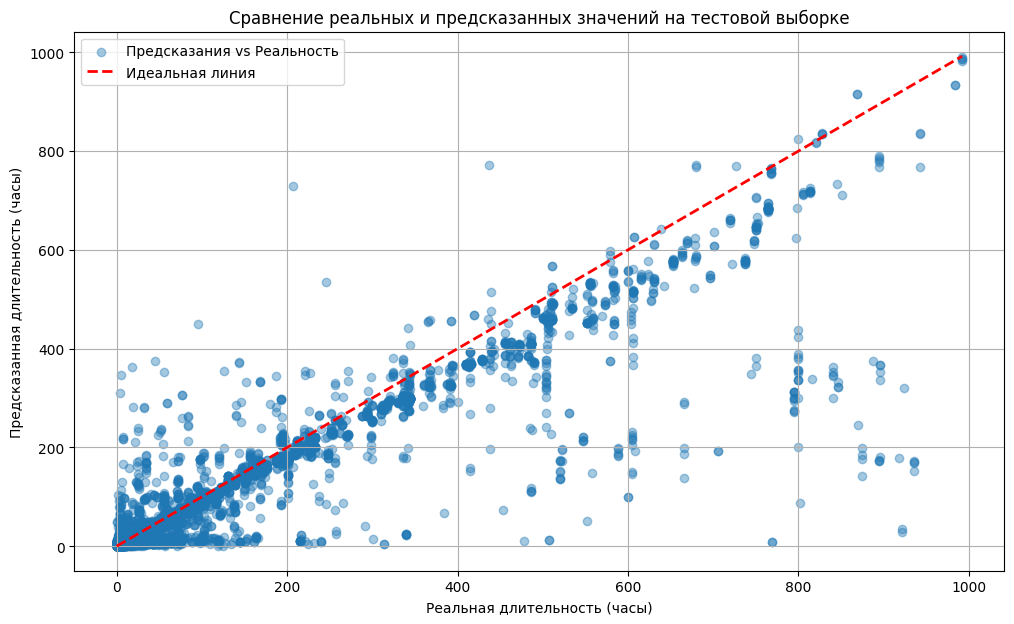

In [7]:
# --- 8. Оценка модели на тестовой выборке ---

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for features, labels in test_loader:
        features = features.to(DEVICE)
        outputs = model(features)
        all_preds.extend(outputs.cpu().numpy())
        all_labels.extend(labels.numpy())

# Преобразование в numpy массивы
all_preds = np.array(all_preds).flatten()
all_labels = np.array(all_labels).flatten()

# Расчет метрик
rmse = np.sqrt(mean_squared_error(all_labels, all_preds))
r2 = r2_score(all_labels, all_preds)

print("\n--- Оценка на тестовой выборке ---")
print(f"RMSE (Root Mean Squared Error): {rmse:.4f}")
print(f"R^2 Score: {r2:.4f}")

# --- 9. Визуализация результатов ---
plt.figure(figsize=(12, 7))

# График рассеяния
plt.scatter(all_labels, all_preds, alpha=0.4, label='Предсказания vs Реальность')

# Идеальная линия
plt.plot([min(all_labels), max(all_labels)], [min(all_labels), max(all_labels)], 'r--', lw=2, label='Идеальная линия')

plt.xlabel("Реальная длительность (часы)")
plt.ylabel("Предсказанная длительность (часы)")
plt.title("Сравнение реальных и предсказанных значений на тестовой выборке")
plt.legend()
plt.grid(True)
plt.show()